# Skincancer HAM-dataset med Pytorch/ONNX from Matlab

### Standardimporter

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import onnx

import numpy as np
import pandas as pd
#from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### Visa om CPU eller GPU finns tillgänglig:

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [23]:
device = get_default_device()

In [24]:
print(device)

cuda


### De båda nedanstående blocken används för att enkelt flytta till GPU: 

In [25]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [26]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
do_training = False

In [28]:
if torch.cuda.is_available():
    print('gpu')
else:
    print('cpu')

gpu


### Definiera en modell:

In [29]:
!pwd

/home/johan/cloud-storage/Dropbox/coding/python-ml/pytorch/skincancer_ham_pytorch


In [30]:
# Nedanstående två rader måste göras oavsett träning eller ej:

# Load the ONNX model
onnx_filename = "../../../Matlab-ML/skin_cancer_ham/models/alexNet_bal_data.onnx"
model = onnx.load(onnx_filename)

In [31]:
# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)

#print(model)

'graph Network (\n  %data[FLOAT, 1x3x227x227]\n) optional inputs with matching initializers (\n  %data_Mean[FLOAT, 1x3x1x1]\n  %conv1_W[FLOAT, 96x3x11x11]\n  %conv1_B[FLOAT, 96]\n  %conv2_W[FLOAT, 256x48x5x5]\n  %conv2_B[FLOAT, 256]\n  %conv3_W[FLOAT, 384x256x3x3]\n  %conv3_B[FLOAT, 384]\n  %conv4_W[FLOAT, 384x192x3x3]\n  %conv4_B[FLOAT, 384]\n  %conv5_W[FLOAT, 256x192x3x3]\n  %conv5_B[FLOAT, 256]\n  %fc6_W[FLOAT, 4096x256x6x6]\n  %fc6_B[FLOAT, 4096]\n  %fc7_W[FLOAT, 4096x4096x1x1]\n  %fc7_B[FLOAT, 4096]\n  %NewFC_W[FLOAT, 7x4096x1x1]\n  %NewFC_B[FLOAT, 7]\n) {\n  %data_Sub = Sub(%data, %data_Mean)\n  %conv1 = Conv[dilations = [1, 1], group = 1, kernel_shape = [11, 11], pads = [0, 0, 0, 0], strides = [4, 4]](%data_Sub, %conv1_W, %conv1_B)\n  %relu1 = Relu(%conv1)\n  %norm1 = LRN[alpha = 9.99999974737875e-05, beta = 0.75, bias = 1, size = 5](%relu1)\n  %pool1 = MaxPool[kernel_shape = [3, 3], pads = [0, 0, 0, 0], strides = [2, 2]](%norm1)\n  %conv2 = Conv[dilations = [1, 1], group = 2, k

### Flytta modellen till GPU, om en sådan finns:

In [29]:
# Flytta modellen till GPU:

to_device(model, device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [30]:
# Verifiera att modellen är på rätt device:
# True => modellen finns på GPU.

next(model.parameters()).is_cuda

True

### Definiera de olika mängderna för träning, validering och test:

In [11]:
batchsz = 32
train_num_workers = 4
test_val_num_workers = 8

img_w = 224
img_h = 224
img_dim = 3


# Definiera vilken augmentation som ska göras:
train_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_w),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

val_test_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_w),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

basepath = "../../../ml/Datasets/skin-cancer-mnist-ham10000/images_per_label_splitted_sets_balanced/"

# Definiera de tre dataseten:
skincancer_train_dataset = datasets.ImageFolder(root = basepath + 'train/',
                                           transform = train_data_transform)

skincancer_valid_dataset = datasets.ImageFolder(root = basepath + 'val/',
                                           transform = val_test_data_transform)

skincancer_test_dataset = datasets.ImageFolder(root = basepath + 'test/',
                                              transform = val_test_data_transform)

In [12]:
batchsz_val = 2**6
batchsz_test = 2**3

# Skapa loaders för de tre dataseten:
train_loader = torch.utils.data.DataLoader(skincancer_train_dataset,
                                             batch_size = batchsz, 
                                             shuffle = True,
                                             pin_memory = True,
                                             drop_last = True,
                                             num_workers = train_num_workers)

valid_loader = torch.utils.data.DataLoader(skincancer_valid_dataset,
                                             batch_size = batchsz, 
                                             shuffle = True,
                                             num_workers = test_val_num_workers)

test_loader = torch.utils.data.DataLoader(skincancer_test_dataset,
                                             batch_size = batchsz_test, 
                                             shuffle = False,
                                             num_workers = test_val_num_workers)

### Skapa en weighted loader som hanterar obalansen mellan klasserna:

In [13]:
train_targets = train_loader.dataset.targets
print(len(train_targets))

14553


In [14]:
from torch.utils.data import WeightedRandomSampler

In [15]:
# Test för att oversampla vissa klasser...
# https://discuss.pytorch.org/t/how-to-implement-oversampling-in-cifar-10/16964/6

train_targets = train_loader.dataset.targets
class_count = np.unique(train_targets, return_counts=True)[1]
#print("Antal bilder per klass = ", class_count, "\n")

# Testa att köra med 1 / sevenones för att se en obalanserad, vanlig, loader
# och med 1 / class_count för att se hur det balanserade resultatet blir:

# sevenones = np.ones(7)
# weight = 1 / sevenones
weight = 1. / class_count
samples_weight = weight[train_targets]
samples_weight = torch.from_numpy(samples_weight)

# Replacement = True ger dragning med återläggning, vilket vi ska ha, 
# annars kommer de mindre klasserna "ta slut" i dragningen:
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [16]:
# Skapa en ny dataloader baserad på 
# träningssetet som är viktad klassivs:

# "pin_memory=True" gör att man flyttar data till GPU:n medan 
# vi kör träningen, vilket påskyndar arbetet radikalt, ffa
# om vi har komplexa modeller.
train_loader_weighted = DataLoader(skincancer_train_dataset, 
                             batch_size = batchsz, 
                             sampler = sampler, # kan ej ha shuffle = True med sampler!
                             pin_memory=True,
                             drop_last=True,
                             num_workers = train_num_workers)

### Flytta *_loader till rätt device

In [83]:
train_dl = DeviceDataLoader(train_loader, device)
train_dl_weighted = DeviceDataLoader(train_loader_weighted, device)
valid_dl = DeviceDataLoader(valid_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

In [38]:
print(train_dl.device, train_dl_weighted.device, valid_dl.device, test_dl.device)

cuda cuda cuda cuda


## Visa skillnader mellan oviktad och viktad loader:

### Visa batcher med den viktade train_loadern:

In [39]:
print("Antal bilder per klass = ", class_count, "\n")

# Visa hur den drar samples från klasserna för fyra batcher:
for batch_idx, (data, target) in enumerate(train_loader_weighted):
    print('Batch {}, classes {}, count {}'.format(
        batch_idx, *np.unique(target.numpy(), return_counts=True)))
    if batch_idx == 3:
        break

Antal bilder per klass =  [1824 1436 1538 1920 1558 4693 1584] 

Batch 0, classes [0 1 2 3 4 5 6], count [ 2 10  9  2  4  1  4]
Batch 1, classes [0 1 2 3 4 5 6], count [5 3 4 2 6 5 7]
Batch 2, classes [0 1 2 3 4 5 6], count [7 6 1 5 2 5 6]
Batch 3, classes [0 1 2 3 4 5 6], count [2 8 3 3 6 6 4]


### Visa batcher med vanliga train_loadern:

In [42]:
print("Antal bilder per klass = ", class_count, "\n")

# Visa hur den drar samples från klasserna för fyra batcher:
for batch_idx, (data, target) in enumerate(train_loader):
    print('Batch {}, classes {}, count {}'.format(
        batch_idx, *np.unique(target.numpy(), return_counts=True)))
    if batch_idx == 3:
        break

Antal bilder per klass =  [1824 1436 1538 1920 1558 4693 1584] 

Batch 0, classes [0 1 2 3 4 5 6], count [6 3 1 5 5 8 4]
Batch 1, classes [0 1 3 4 5 6], count [ 5  2  7  5 10  3]
Batch 2, classes [0 1 2 3 4 5 6], count [ 6  1  2  4  2 14  3]
Batch 3, classes [0 1 2 3 4 5 6], count [ 6  2  3  2  4 11  4]


In [43]:
type(target)

torch.Tensor

In [44]:
len(target) # ger en vektor med batchsz i storlek.

# Kolla t.ex. hur många samples ur klass A som finns i sista batchen ovan:
A = 0
np.sum(target.numpy() == A)

6

### Visa en batch med bilder och deras klasser:

In [45]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [46]:
# Get a batch of training data
images, classes = next(iter(train_loader))
class_names = train_loader.dataset.classes

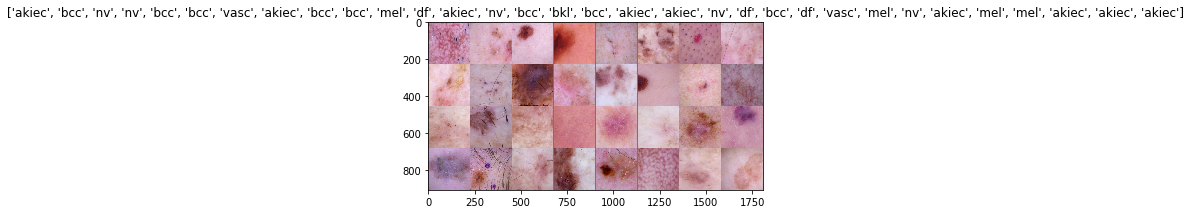

In [47]:
# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title = [class_names[x] for x in classes])

In [48]:
# Visa dimensionerna för en bild-tensor (batchsize, number of channels, width, height):
images.shape

torch.Size([32, 3, 224, 224])

In [49]:
torch.manual_seed(17)

In [50]:
trainableparameters = []
for param in model.parameters():
    # trainableparameters = param.numel()
    trainableparameters.append(param.numel())

print("Antalet träningsbara parametrar är =", np.sum(trainableparameters), "st.")


Antalet träningsbara parametrar är = 2232839 st.


### Definiera loss-function och vilken metod för optimering som ska användas:

In [17]:
# Definiera loss-function och vilken optimerare som ska användas:

learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

AttributeError: parameters

In [52]:
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

### Look at one batch and on which device it is run

In [ ]:
for X_train, y_train in train_dl_weighted:
    print('X_train.device:', X_train.device)
    print('y_train.device:', y_train.device)
    break

In [ ]:
for X_valid, y_valid in valid_dl:
    print('X_valid.device:', X_valid.device)
    print('y_valid.device:', y_valid.device)
    break

In [ ]:
for X_test, y_test in test_dl:
    print('X_test.device:', X_test.device)
    print('y_test.device:', y_test.device)
    break

## Följande återställer modellens vikter mellan olika körningar

In [58]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

### Overfit på en batch för att se att modellen är rimlig

In [ ]:
torch.manual_seed(17)

if do_training == True:
    model.apply(weights_init)

    inputs, labels = next(iter(train_dl_weighted))
    inputs = inputs.to(device)
    labels = labels.to(device)

    criterion_check1 = nn.CrossEntropyLoss()
    optimizer_check1 = optim.Adam(model.parameters(), lr = learning_rate)

    model.train()
    for epoch in range(31):
        optimizer_check1.zero_grad()
        outputs = model(inputs)
        loss = criterion_check1(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer_check1.step()
        correct = torch.sum(preds == labels)
    
        if epoch%10 == 0:
            print(f'Epok {epoch:02}: ----- loss = {loss:4.4f} ----- accuracy = {correct}')
else:
    pass

## Trainingloop (utan validation):

In [ ]:
import time
epochs = 128

if do_training == True:
    start_training_time = time.time()

    # Nollställer vikterna i modellen:
    model.apply(weights_init)

    # Nedan för att vi använder "droplast = True"
    num_iter = np.floor_divide(len(train_loader.dataset), batchsz)
    no_training_images = batchsz * np.floor_divide(len(train_loader.dataset), batchsz)

    train_accuracy = []
    train_losses = []

    # Sätt modellen i träningsläge:
    model.train()

    for epoch in range(epochs):
        start_epoch_time = time.time()
        train_correct_pred_per_epoch = 0
    
        current_loss = 0.0
        current_corrects = 0
    
        # Antal iterationer i for-loopen = floor(7007/128) = 54 st. dvs 
        # antalet bilder i träningssetet delat med batch_size.
    
        for inputs, labels in train_dl_weighted:
            predictions = model(inputs)
            optimizer.zero_grad()
        
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
        
            #exp_lr_scheduler.step()
            # Nedan ger den mest troliga klassen:
            _, predicted = torch.max(predictions, 1)
    
            current_loss += loss.item() * inputs.size(0) # * batchsz...
            current_corrects += torch.sum(predicted == labels.data)

        epoch_loss = np.float64(current_loss / no_training_images)
        epoch_acc = np.float64(current_corrects.double() / no_training_images)
    
        # Lagra accuracy och loss per epok för t.ex. plottning:
        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_acc)
    
        end_epoch_time = time.time()
        epoch_time = end_epoch_time - start_epoch_time
        # epoch startar på 0, därav "+1" nedan:
        print(f"Epok {epoch + 1:02}: {epoch_time:2.1f} sek, accuracy = {epoch_acc:4.3f}, loss = {epoch_loss:4.4f}")
    
    end_training_time = time.time()

    delta = end_training_time - start_training_time

    print(f'\nTraining took {delta:.2f} seconds.')
else:
    pass

## Träning och validering:

In [60]:
import time
epochs = 128

if do_training == True:
    start_training_time = time.time()

    # Nollställer vikterna i modellen:
    model.apply(weights_init)

    # Nedan för att vi använder "droplast = True"
    # num_iter_train = np.floor_divide(len(train_loader.dataset), batchsz)
    num_train_images = batchsz * np.floor_divide(len(train_loader.dataset), batchsz)
    
    # Validation:
    # num_iter_val = np.floor_divide(len(valid_loader.dataset), batchsz)
    num_val_images = batchsz * np.floor_divide(len(valid_loader.dataset), batchsz)

    train_accuracy = []
    train_losses = []
    
    val_accuracy = []
    val_losses = []


    for epoch in range(epochs):
        start_epoch_time = time.time()
        train_correct_pred_per_epoch = 0
    
        current_train_loss = 0.0
        current_train_corrects = 0
        
        # Sätt modellen i träningsläge:
        start_train_time = time.time()
        model.train()
        
        for inputs_train, labels_train in train_dl_weighted:
            train_predictions = model.forward(inputs_train)
            optimizer.zero_grad()
        
            train_loss = criterion(train_predictions, labels_train)
            train_loss.backward()
            
            optimizer.step()
        
            #exp_lr_scheduler.step()
            #lr = exp_lr_scheduler.get_lr()
            
            # Nedan ger den mest troliga klassen:
            _, train_predicted = torch.max(train_predictions, 1)
    
            current_train_loss += train_loss.item() * batchsz
            current_train_corrects += torch.sum(train_predicted == labels_train.data)
        
        end_train_time = time.time()
    
        # Sätt modellen i utvärderingsläge:
        start_eval_time = time.time()
        model.eval()
        
        current_val_loss = 0.0
        current_val_corrects = 0
        
        with torch.no_grad():
            
            inputs_val, labels_val = next(iter(valid_dl))
            val_predictions = model.forward(inputs_val)
            val_loss = criterion(val_predictions, labels_val)
            _, val_predicted = torch.max(val_predictions, 1)
            current_val_loss += val_loss.item() * batchsz
            current_val_corrects += torch.sum(val_predicted == labels_val.data)
        
        end_eval_time = time.time()
        
        # Räkna ut acc och loss per epok:
        epoch_train_loss = np.float64(current_train_loss / num_train_images)
        epoch_train_acc = np.float64(current_train_corrects.double() / num_train_images)
        
        epoch_val_loss = np.float64(current_val_loss / batchsz)
        epoch_val_acc = np.float64(current_val_corrects.double() / batchsz)
        
        # Lagra accuracy och loss per epok för t.ex. plottning:
        train_losses.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)
        
        val_losses.append(epoch_val_loss)
        val_accuracy.append(epoch_val_acc)
        
        # Räkna ut tiderna:
        end_epoch_time = time.time()
        epoch_time = end_epoch_time - start_epoch_time
        
        # epoch startar på 0, därav "+1" nedan:
        print(f"Epok {epoch + 1:02}: {epoch_time:2.1f} sek, train-acc = {epoch_train_acc:4.3f}, val-acc = {epoch_val_acc:4.3f}, train-loss = {epoch_train_loss:4.4f}, val-loss = {epoch_val_loss:4.4f}")
    
    end_training_time = time.time()

    delta = end_training_time - start_training_time

    print(f'\nTraining took {delta:.2f} seconds.')
else:
    pass

Epok 01: 72.0 sek, train-acc = 0.436, val-acc = 0.469, train-loss = 1.4644, val-loss = 1.3655
Epok 02: 71.3 sek, train-acc = 0.504, val-acc = 0.750, train-loss = 1.3000, val-loss = 0.9870
Epok 03: 71.9 sek, train-acc = 0.550, val-acc = 0.500, train-loss = 1.1930, val-loss = 1.4230
Epok 04: 71.9 sek, train-acc = 0.584, val-acc = 0.562, train-loss = 1.1013, val-loss = 1.0203
Epok 05: 71.3 sek, train-acc = 0.611, val-acc = 0.656, train-loss = 1.0470, val-loss = 1.1590
Epok 06: 72.5 sek, train-acc = 0.634, val-acc = 0.469, train-loss = 0.9862, val-loss = 1.0444
Epok 07: 71.4 sek, train-acc = 0.643, val-acc = 0.438, train-loss = 0.9643, val-loss = 1.5749
Epok 08: 71.3 sek, train-acc = 0.666, val-acc = 0.656, train-loss = 0.9094, val-loss = 0.7509
Epok 09: 71.3 sek, train-acc = 0.677, val-acc = 0.531, train-loss = 0.8766, val-loss = 1.1737
Epok 10: 71.0 sek, train-acc = 0.689, val-acc = 0.438, train-loss = 0.8502, val-loss = 1.3557
Epok 11: 72.4 sek, train-acc = 0.693, val-acc = 0.594, train

Epok 89: 72.3 sek, train-acc = 0.895, val-acc = 0.781, train-loss = 0.2994, val-loss = 0.9311
Epok 90: 72.0 sek, train-acc = 0.888, val-acc = 0.781, train-loss = 0.3028, val-loss = 0.7057
Epok 91: 71.7 sek, train-acc = 0.895, val-acc = 0.719, train-loss = 0.2877, val-loss = 0.8902
Epok 92: 71.1 sek, train-acc = 0.891, val-acc = 0.594, train-loss = 0.2901, val-loss = 1.8487
Epok 93: 71.1 sek, train-acc = 0.898, val-acc = 0.656, train-loss = 0.2850, val-loss = 1.5665
Epok 94: 72.5 sek, train-acc = 0.897, val-acc = 0.688, train-loss = 0.2843, val-loss = 1.0393
Epok 95: 71.2 sek, train-acc = 0.903, val-acc = 0.625, train-loss = 0.2695, val-loss = 1.3856
Epok 96: 72.5 sek, train-acc = 0.899, val-acc = 0.719, train-loss = 0.2786, val-loss = 1.1289
Epok 97: 71.1 sek, train-acc = 0.903, val-acc = 0.656, train-loss = 0.2677, val-loss = 0.9878
Epok 98: 72.1 sek, train-acc = 0.905, val-acc = 0.812, train-loss = 0.2637, val-loss = 0.6671
Epok 99: 72.1 sek, train-acc = 0.898, val-acc = 0.844, train

In [53]:
# https://pytorch.org/docs/master/notes/serialization.html

if do_training:
    model_save_name = "trained_models/mobilenet_v2_e128_b32.pt"
    # path = model_save_name
    torch.save(model.state_dict(), model_save_name)
else:
    pass

In [54]:
import pandas as pd

if do_training == True:
    training_log = pd.DataFrame(data={"epoch": range(epochs), "train_acc": train_accuracy, "train_loss": train_losses,  "val_acc": val_accuracy, "val_loss": val_losses})
    training_log.to_csv("logs/mobilenet_v2_e128_b32.csv", sep=',',index = False)
    #training_log = pd.read_csv('logs/mobilenet_v2_e64_b32.csv')
else:
    training_log = pd.read_csv('logs/mobilenet_v2_e128_b32.csv')

In [55]:
training_log.head()

,epoch,train_acc,train_loss,val_acc,val_loss
0,0,0.435710,1.464365,0.46875,1.365501
1,1,0.503786,1.300012,0.75000,0.986982
2,2,0.549766,1.193026,0.50000,1.422955
3,3,0.583838,1.101321,0.56250,1.020350
4,4,0.611027,1.047024,0.65625,1.158956


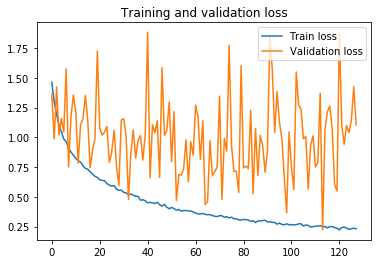

In [56]:
plt.plot(training_log['epoch'], training_log['train_loss'])
#plt.title("Loss on the training set over the epochs")
# plt.yticks(np.arange(0, 50, step = 5))
# plt.ylim(0,50)
#plt.show()

# Plotta accuracy över valideringsdatat:
plt.plot(training_log['epoch'], training_log['val_loss'])
plt.title("Training and validation loss")
#plt.yticks(np.arange(0, 1.1, step = 0.2))
#plt.ylim(0, max())
plt.legend(['Train loss', 'Validation loss'], loc = 'upper right')
plt.show()


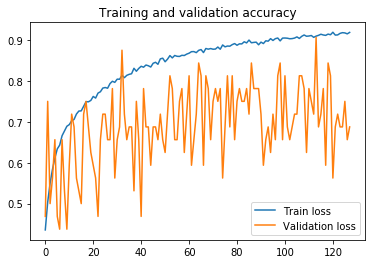

In [57]:
plt.plot(training_log['epoch'], training_log['train_acc'])
#plt.title("Loss on the training set over the epochs")
# plt.yticks(np.arange(0, 50, step = 5))
# plt.ylim(0,50)
#plt.show()

# Plotta accuracy över valideringsdatat:
plt.plot(training_log['epoch'], training_log['val_acc'])
plt.title("Training and validation accuracy")
#plt.yticks(np.arange(0, 1.1, step = 0.2))
#plt.ylim(0, max())
plt.legend(['Train loss', 'Validation loss'], loc = 'lower right')
plt.show()

In [58]:
max_train_acc = 100*max(training_log['train_acc'])

In [66]:
mean_val_acc = training_log['val_acc'].mean()

In [67]:
print(f'Max tränings-accuracy = {max_train_acc:.2f} %.')

Max tränings-accuracy = 91.89 %.


In [68]:
print(f'Medel för validering-accuracy = {100*mean_val_acc:.2f} %.')

Medel för validering-accuracy = 69.12 %.


### Utvärdera på valideringsmängden:

In [20]:
# Sätt modellen i utvärderingsläge:
#model.eval()

valid_correct_pred_per_epoch = 0
valid_accuracy = []
valid_losses = []

no_valid_images = len(valid_loader.dataset) # = 998
with torch.no_grad():
    # Antal iterationer = 998 / 16 = 63 st.
    for X_valid, y_valid in valid_loader:

        y_valid_pred = model(X_valid)
        
        valid_predicted = torch.max(y_valid_pred.data, 1)[1]
        valid_is_correct = (valid_predicted == y_valid).sum()
        valid_correct_pred_per_epoch += valid_is_correct
        
        valid_loss = criterion(y_valid_pred, y_valid)
        valid_losses.append(valid_loss.item())
            
        valid_epoch_accuracy = valid_correct_pred_per_epoch.item() / no_valid_images
        valid_accuracy.append(valid_epoch_accuracy)
        
# epoch startar på 0, därav "+1" nedan:
print(f"Validering: accuracy = {valid_epoch_accuracy:4.4f} och loss är = {valid_loss:4.4f}")

TypeError: 'ModelProto' object is not callable

### Utvärdera modellen på test-set

In [89]:
import time

model.eval()

no_test_images = len(valid_loader.dataset) #len(test_loader.dataset)

start_eval_test_time = time.time()
with torch.no_grad():
    correct = 0
    # Antal iterationer = 2010 / 16 = 123 st.
    for X_test, y_test in valid_dl:
        y_pred_test = model.forward(X_test)
        predicted = torch.max(input = y_pred_test, dim = 1)[1]
        correct += (predicted == y_test).sum()
    end_eval_test_time = time.time()
eval_test_time = end_eval_test_time - start_eval_test_time
print(f'Test accuracy: {correct.item()}/{no_test_images} = {correct.item()*100/(no_test_images):5.2f} %')
print("\nEvaluation took", eval_test_time, "seconds.")

OSError: Caught OSError in DataLoader worker process 5.
Original Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\pytorch_general\lib\site-packages\torch\utils\data\_utils\worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\ProgramData\Anaconda3\envs\pytorch_general\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\ProgramData\Anaconda3\envs\pytorch_general\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\ProgramData\Anaconda3\envs\pytorch_general\lib\site-packages\torchvision\datasets\folder.py", line 138, in __getitem__
    sample = self.loader(path)
  File "C:\ProgramData\Anaconda3\envs\pytorch_general\lib\site-packages\torchvision\datasets\folder.py", line 174, in default_loader
    return pil_loader(path)
  File "C:\ProgramData\Anaconda3\envs\pytorch_general\lib\site-packages\torchvision\datasets\folder.py", line 157, in pil_loader
    return img.convert('RGB')
  File "C:\ProgramData\Anaconda3\envs\pytorch_general\lib\site-packages\PIL\Image.py", line 930, in convert
    self.load()
  File "C:\ProgramData\Anaconda3\envs\pytorch_general\lib\site-packages\PIL\ImageFile.py", line 272, in load
    raise_ioerror(err_code)
  File "C:\ProgramData\Anaconda3\envs\pytorch_general\lib\site-packages\PIL\ImageFile.py", line 59, in raise_ioerror
    raise IOError(message + " when reading image file")
OSError: broken data stream when reading image file


### Visualisera modellens förutsägelser

In [70]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

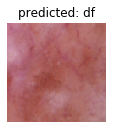

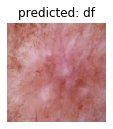

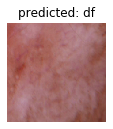

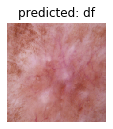

In [71]:
visualize_model(model, 4)

In [72]:
# Skapa en confusion matrix mha scikit-learn
# Skapa en classification report mha scikit-learn
# Är det skillnad mellan träningslooparna ovan?
# Varför dras samples ur de olika trainloaders så olika? Varför är inte alla klasser med i alla batcher?

### Confusion matrix

In [73]:
from sklearn.metrics import confusion_matrix
number_of_classes = len(test_loader.dataset.classes)

In [74]:
y_true = test_loader.dataset.targets

In [48]:
X_test = test_loader.

In [ ]:
confusion_matrix(y_true, y_pred)

In [43]:
def pytorch_confusion_matrix(num_classes, model, dataloader):
    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            predictions = model(inputs)
            _, preds = torch.max(predictions, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    return print(confusion_matrix)

In [44]:
cm_test = pytorch_confusion_matrix(number_of_classes, model, test_loader)

tensor([[567., 158., 201.,  52.,  70.,  17.,   7.],
        [ 69., 974.,  75.,  23.,  57.,  30.,  20.],
        [ 33.,  24., 657.,  17.,  93.,  55.,   5.],
        [ 24.,  72.,  53., 501.,  58.,  37.,  23.],
        [  3.,  23., 182.,   4., 572.,  92.,  16.],
        [  5.,  31., 121.,  22., 179., 967.,  17.],
        [  1.,  15.,  11.,  27.,  24.,  16., 834.]])


In [45]:
cm_train = pytorch_confusion_matrix(number_of_classes, model, train_loader)

tensor([[545., 182., 188.,  52.,  83.,  19.,   3.],
        [ 69., 965.,  72.,  25.,  64.,  21.,  32.],
        [ 28.,  26., 643.,  20., 112.,  49.,   6.],
        [ 24.,  61.,  60., 517.,  58.,  42.,   6.],
        [ 14.,  24., 184.,   7., 555.,  93.,  15.],
        [ 10.,  31., 101.,  15., 190., 971.,  24.],
        [  3.,  13.,  10.,  18.,  30.,   9., 845.]])


In [ ]:
cm_train_np = np.asarray(cm_train)

In [ ]:
cm_train_np.shape